In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from single_state_mdp import SingleStateMDP, plot_mdp_reward
import random

In [3]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cpu"

In [4]:
def quantile_huber_loss_f(quantiles, samples):
    pairwise_delta = samples[None, None, :] - quantiles[:, :, None]  # nets x quantiles x samples
    abs_pairwise_delta = torch.abs(pairwise_delta)
    huber_loss = torch.where(abs_pairwise_delta > 1,
                             abs_pairwise_delta - 0.5,
                             pairwise_delta ** 2 * 0.5)

    n_quantiles = quantiles.shape[1]
    tau = torch.arange(n_quantiles, device=DEVICE).float() / n_quantiles + 1 / 2 / n_quantiles
    loss = (torch.abs(tau[None, :, None] - (pairwise_delta < 0).float()) * huber_loss).mean()
    return loss

In [18]:
class Mlp(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.fcs = []
        in_size = input_size
        for i, next_size in enumerate(hidden_sizes):
            fc = nn.Linear(in_size, next_size)
            self.add_module(f"fc{i}", fc)
            self.fcs.append(fc)
            in_size = next_size
        self.last_fc = nn.Linear(in_size, output_size)

    def forward(self, input):
        h = input
        for fc in self.fcs:
            h = F.relu(fc(h))
        output = self.last_fc(h)
        return output


class Critic(nn.Module):
    def __init__(
        self,
        state_dim,
        action_dim,
        n_nets,
        n_quantiles
    ):
        super().__init__()
        self.nets = []
        self.n_quantiles = n_quantiles
        self.n_nets = n_nets

        # Define a list of Q-networks with the given architecture
        for i in range(n_nets):
            net = Mlp(state_dim + action_dim, [50, 50], n_quantiles)
            self.add_module(f"qf{i}", net)
            self.nets.append(net)

    def forward(self, state, action):
        # sa = torch.tensor((state, action)).reshape(1, -1)
        sa = torch.tensor((state, action))
        quantiles = torch.stack(tuple(net(sa) for net in self.nets), dim=1)
        return quantiles


class Trainer:
    def __init__(
        self, critic, gamma, dropped_quantiles=1, bias_correction_method="TQC"
    ):
        self.critic = critic
        self.gamma = gamma
        self.dropped_quantiles = dropped_quantiles
        self.bias_correction_method = bias_correction_method

        self.optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.quantiles_total = critic.n_quantiles * critic.n_nets

    def train(self, replay_buffer, num_iterations=3000, verbose=0):
        for i in range(num_iterations):
            # Sample a batch of transitions from the replay buffer
            state, action, reward, next_state, done = replay_buffer.sample()

            if self.bias_correction_method == "AVG":
                # Calculate the loss using the mean of the Q-value distribution
                with torch.no_grad():
                    next_q = self.critic(next_state, action)
                    avg_q = next_q.mean(dim=1)
                    target = reward + (1. - done) * self.gamma * avg_q

                loss = F.mse_loss(avg_q, target)

            elif self.bias_correction_method == "MIN":
                # Calculate the loss using the minimum value of the Q-value distribution
                with torch.no_grad():
                    next_q = self.critic(next_state, action)
                    min_q = next_q.min(dim=1)
                    target = reward + (1. - done) * self.gamma * min_q

                loss = F.mse_loss(min_q, target)

            elif self.bias_correction_method == "TQC":
                # Calculate the loss using the TQC bias correction method
                with torch.no_grad():
                    next_z = self.critic(next_state, action)

                    sorted_z, _ = torch.sort(next_z.reshape(1, -1))
                    sorted_z_part = sorted_z[
                        :, : self.quantiles_total - self.dropped_quantiles
                    ]

                    target = reward + self.gamma * sorted_z_part # * a_star

                cur_z = self.critic(next_state, action)
                loss = quantile_huber_loss_f(cur_z, target)
                
                if verbose:
                    print(loss)

            # Backpropagate the loss and update the weights
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def predict(self, action_grid):
        # Initialize an array to store the Q-values for each action
        q_values = []
        state = 0

        # Evaluate the critic network on the given state and each action in the grid
        for action in action_grid:
            z_values = self.critic(state, action)
            approx = z_values.mean().item()
            q_values.append(approx)

        # Convert the list of Q-values to a tensor
        q_values = torch.tensor(q_values)

        # Return the argmax over the quantiles dimension
        return action_grid[q_values.argmax()]


class ReplayBuffer:
    def __init__(self, env, size):
        self.transitions = []

        for action in np.linspace(-1.0, 1.0, size):
            state = 0
            next_state, reward, done, _ = env.step(action)
            self.transitions.append((state, action, reward, next_state, done))

    def sample(self):
        return random.choice(self.transitions)
    

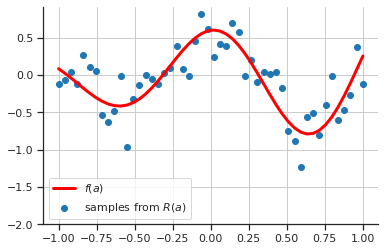

tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.1924, grad_fn=<MeanBackward0>)
tensor(0.0357, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.2489, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0293, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0382, grad_fn=<MeanBackward0>)
tensor(0.0895, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<MeanBackward0>)
tensor(0.0620, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.1865, grad_fn=<MeanBackward0>)
tensor(0.0479, grad_fn=<MeanBackward0>)
tensor(0.0319, grad_fn=<MeanBackward0>)
tensor(0.0364, grad_fn=<MeanBackward0>)
tensor(0.1392, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)


tensor(0.0595)

In [19]:
# Setup env
env = SingleStateMDP()
# env = SingleStateMDP(A0=0.1, A1=0.9, nu=8)
state_dim = env.observation_space.n
action_dim = env.action_space.shape[0]

plot_mdp_reward(50, env)

# Setup replay buffer
replay_buffer = ReplayBuffer(env, 50)

# Setup Q-networks
critic = Critic(state_dim, action_dim, 2, 25)
trainer = Trainer(critic, 0.99, 16, bias_correction_method="TQC")

# Training the critic
trainer.train(replay_buffer, 3000, verbose=1)

# Define a dense grid of actions
action_grid = torch.linspace(-1, 1, 2000)

# Get the argmax action for a given state
a_star = trainer.predict(action_grid)
a_star